### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'PMG 247 monitoring'

In [4]:
experiment_names = ['Saccharose hydrolysis',
                   'Silane',
                   'PMG 247 monitoring']

In [5]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_1000/all.csv',
                'Silane': '../data/silan/pmg166_3rdseries_full.csv',
                'PMG 247 monitoring': '../data/PMG_247/preprocessed_PMG247_monitoring.csv'
                }

mixture_separators = {'Saccharose hydrolysis': '\t',
                'Silane': ',',
                'PMG 247 monitoring': ','
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_1000/comparing_with_previous/unknown_substrats/',
                'Silane': '../results/silan/comparing_with_previous/unknown_substrats/',
                'PMG 247 monitoring': '../results/PMG_247/comparing_with_previous/unknown_substrats/'
                }

#### Mixture in time

In [6]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    mixture_time_data = mixture_time_data.iloc[:,:-1]

In [7]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [8]:
mixture_time_data.columns = names

In [9]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    return sp

In [10]:
sp1 = load_spectrum(mixture_time_data, 1)
sp_last = load_spectrum(mixture_time_data, mixture_time_data.shape[1]-1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


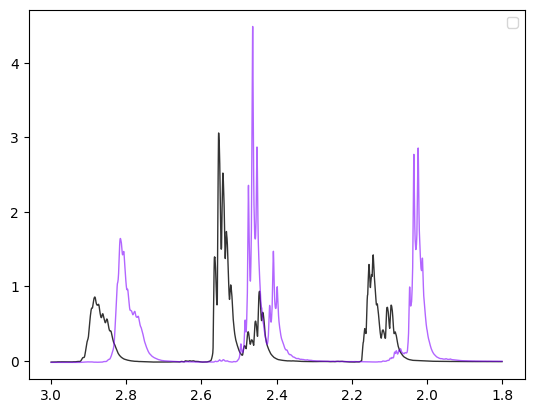

In [11]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all([sp1, sp_last], profile=True)

### Preprocessing (optional)

In [12]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(NMRSpectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [13]:
if experiment_name == 'Silane':
    preprocessed_spectra = [load_spectrum(mixture_time_data, i) for i in range(1, mixture_time_data.shape[1])]
    preprocessed_spectra = cut_spectra_to_region(preprocessed_spectra, 0, 8)
    ppm = np.array(list(preprocessed_spectra[0].confs))[:,0]
    ints = [np.array(list(preprocessed_spectra[i].confs))[:,1] for i in range(len(preprocessed_spectra))]
    mixture_time_data = np.stack([ppm]+ints).T
    mixture_time_data = pd.DataFrame(mixture_time_data, columns = names)

### Estimation

In [14]:
kappa = 0.1
kappa_th = 0.1

In [15]:
proportions_in_times = []
noise_proportions_in_times = []
noise = []

sp1 = load_spectrum(mixture_time_data, 1)
sp1.trim_negative_intensities()
sp1.normalize()

for i in range(2, mixture_time_data.shape[1]):
    print('This is timepoint '+str(i)+'.\n')
    current = load_spectrum(mixture_time_data, i)
    previous = load_spectrum(mixture_time_data, i-1)
    estimation = estimate_proportions(current, [previous], what_to_compare='area',
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)

    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    noise.append(estimation['noise'])
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 2.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 0 is not normalized
Normalizing component's spectrum 0.


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Proportions:

[0.9964928463849992]


Proportion_of_noise_in_components:

0.0012802113599999988


This is timepoint 3.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 0 is not normalized
Normalizing component's spectrum 0.
Proportions:

[0.9964631927090013]


Proportion_of_noise_in_components:

0.0005561375020000008


This is timepoint 4.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Component's spectrum 0 cannot contain negative intensities.
Setting negative intensities to zero.
Component's spectrum 0 is not normalized
Normalizing component's spectrum 0.
Proportions:

[0.9971468227609986]


Proportion_of_noise_in_compon

KeyboardInterrupt: 

In [14]:
len(proportions_in_times)

53

In [15]:
max([prop[0] for prop in proportions_in_times])

1.000000000000004

In [16]:
min([prop[0] for prop in proportions_in_times])

0.9999967557469964

In [17]:
rel_proportions = [1]
for i, prop in enumerate(proportions_in_times):
    rel_proportions.append(rel_proportions[-1]*prop[0])

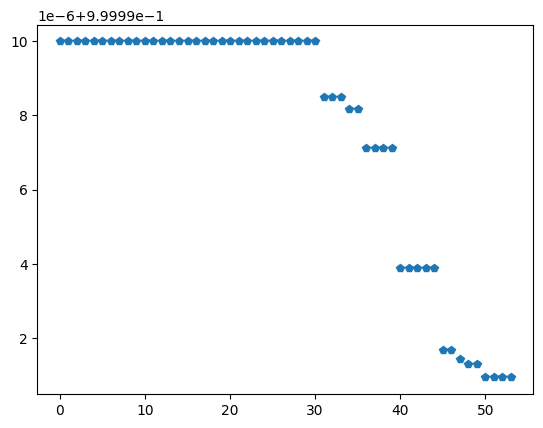

In [18]:
plt.plot(range(1+len(proportions_in_times)), rel_proportions, 'p')

In [19]:
prop = [prop[0] for prop in proportions_in_times]

In [20]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(prop, f)

In [21]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

In [ ]:
with open(results_paths[experiment_name]+'noise_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise, f)

### Reading the results

In [16]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y).reshape(-1,1)